In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.collections import PatchCollection

import random

#python scripts\visualize.py solution-ins-12.txt

def visualize(w, l, n, dims, coords):
    coordsX = [coords[i][0] for i in range(n)]
    coordsY = [coords[i][1] for i in range(n)]
    # print(w, l, n, dims, coordsX, coordsY)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.xlim(0, w)
    plt.ylim(0, l)
    plt.grid(True, color='black')

    myPatches = []
    # myColors = []

    for i in range(n):
        xi_hat = coordsX[i]
        yi_hat = coordsY[i]
        xi = dims[i][0]
        yi = dims[i][1]

        r = patches.Rectangle((xi_hat, yi_hat), xi, yi)
        myPatches.append(r)

    collection = PatchCollection(myPatches, cmap=mpl.cm.hsv, alpha=0.5, edgecolor='black', linewidth=4)
    collection.set_array(np.linspace(0, 254, n, dtype=int))
    #print(np.linspace(0, 200, n, dtype=int))
    collection.set_clim([0, 255])
    ax.add_collection(collection)

    plt.xticks(range(w+1))
    plt.yticks(range(l+1))

    plt.gca().set_aspect('equal', adjustable='box')

    # fig.savefig('figure.png')
    plt.show()

In [169]:
w = 8
n = 4
dims = [[3, 3],
        [3, 5],
        [5, 3],
        [5, 5]]
w = 4
n = 2
dims = [[3, 3],
        [3, 5]]
dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

In [124]:
print(dimsX)
print(dimsY)

[3, 3, 5, 5]
[3, 5, 3, 5]


In [4]:
from z3 import *
from itertools import combinations

In [177]:
def at_least_one(B):
    return Or(B)
def at_most_one(B, name=''):
    return And( [Not(And(pair[0], pair[1])) for pair in combinations(B, 2)] )
    # List which will contain all the formulas for the at_most_one constraint
    """formulas_list = []
    
    n = len(B)  # Number of variables
    
    # Defining the new variables (Note: the indeces start from 0)
    s = [Bool(f's_{name}_{i}') for i in range(n-1)]
    
    # LET'S ADD THE FORMULAS, ONE AT A TIME
    
    # First formula
    formulas_list.append( Or(Not(B[0]), s[0]) )
    
    # Second formula
    formulas_list.append( Or(Not(B[n-1]), Not(s[n-2])) )
    
    # Third big formula
    for i in range(1, n-1):
        formula = And( Or(Not(B[i]),s[i]), Or(Not(s[i-1]),s[i]), Or(Not(B[i]),Not(s[i-1])) )
        formulas_list.append(formula)
        
    # Return the conjunction among all the added formulas
    return And(formulas_list)"""
def exactly_one(B, name=''):
    return And(at_least_one(B), at_most_one(B, name=name))

In [6]:
class UnsatError(BaseException):
    pass

In [386]:
def vlsi_sat(w, n, dimsX, dimsY, formulas=[]):
    s = Solver()
    s.add(And(formulas))
    
    l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                s.add(coords[i][j][k] == And(formula1,formula2))
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])
    return coords_sol, formula
    #else:
    #    return "Unsat" 

In [387]:
%%time
coords_sol, formula = vlsi_sat(w, n, dimsX, dimsY)

Wall time: 3.74 s


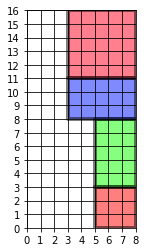

In [388]:
visualize(w, sum(dimsY), n, dims, coords_sol)

In [389]:
coords_sol

[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]

In [7]:
def compute_max_l(coords, dimsY, n):
    return max([coords[i][1]+dimsY[i] for i in range(n)])

In [380]:
compute_max_l(coords_sol, dimsY, n)

11

In [390]:
def optimize(w, n, dimsX, dimsY):
    formulas = []
    
    first = True
    
    #best_l = sum(dimsY)+1
    
    while True:
        try:
            coords_sol, formula = vlsi_sat(w, n, dimsX, dimsY, formulas=formulas)
            formulas.append(Not(formula))
            l = compute_max_l(coords_sol, dimsY, n)
            print(l)
            print(coords_sol)
            if first or l < best_l:
                first = False
                best_coords_sol = coords_sol
                best_l = l
                print(f'best_l {best_l}')
        except UnsatError:
            break
            
    if first:
        return 'Unsat'
    
    return best_coords_sol, best_l              

In [391]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
16
[(2, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(1, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(3, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
16
[(1, 5, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]


KeyboardInterrupt: 

In [179]:
best_coords_sol

[(0, 0), (1, 0)]

In [180]:
best_l

2

In [408]:
def vlsi_sat(w, n, dimsX, dimsY, formulas=[], l_max=None):
    s = Solver()
    s.add(And(formulas))
    
    if not l_max:
        l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                
                formula3 = And([Not(lengths[k][l]) for l in range(j+dimsY[k], l_max)])
                formula4 = And([lengths[k][l] for l in range(j+dimsY[k])])
                
                s.add(coords[i][j][k] == And(formula1, formula2))
                s.add(Implies(coords[i][j][k], And(formula3, formula4)))
                
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])
    l = max([l for k in range(n) for l in range(l_max) if m.evaluate(lengths[k][l])])+1
    return coords_sol, l, formula
    #else:
    #    return "Unsat" 

In [424]:
def vlsi_sat1(w, n, dimsX, dimsY, formulas=[], l_max=None):
    s = Solver()
    s.add(And(formulas))
    
    if not l_max:
        l_max = sum(dimsY)
    #print(f'l_max {l_max}')
    #print()
    
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    #coordsY = [[[Bool('coordY_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))
            
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                #print(f'k {k} i {i} j {j}')
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))
                    continue
                right_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #print(right_positions)
                #wrong_positions = sorted(list(set([(i,j) for i in range(w) for j in range(l_max)]) - set(right_positions)))
                #print(wrong_positions)
                ##all_right_pos = And([circuits[ii][jj][k] for (ii,jj) in right_positions])
                #no_wrong_pos = And([Not(circuits[ii][jj][k]) for (ii,jj) in wrong_positions])
                
                #s.add(Implies(coords[i][j][k], And(all_right_pos, no_wrong_pos)))
                formula1 = And([Not(circuits[ii][jj][kk]) for (ii,jj) in right_positions for kk in range(n) if kk!=k])
                formula2 = And([circuits[ii][jj][k] for (ii,jj) in right_positions ])
                #s.add(Implies(coords[i][j][k], formula))
                
                s.add(coords[i][j][k] == And(formula1, formula2))                
                #print()
                
    #s.add(at_least_one(lengths))
                
    if s.check() != sat:
        raise UnsatError()
    
    # return s
    #if s.check() == sat:
    m = s.model()
    #print(m[coords[1][1][1]])
    #return m

    coords_sol = [(i, j, k) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) for i in range(w) for j in range(l_max) for k in range(n)])

    return coords_sol, formula
    #else:
    #    return "Unsat" 

In [426]:
%%time
coords_sol, formula = vlsi_sat1(w, n, dimsX, dimsY, l_max=8)

Wall time: 1.03 s


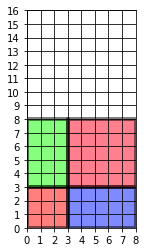

In [427]:
visualize(w, sum(dimsY), n, dims, coords_sol)

In [411]:
l

8

In [412]:
coords_sol

[(5, 0, 0), (5, 3, 1), (0, 5, 2), (0, 0, 3)]

In [400]:
def compute_max_l(coords, dimsY, n):
    return max([coords[i][1]+dimsY[i] for i in range(n)])

In [401]:
compute_max_l(coords_sol, dimsY, n)

16

In [430]:
def optimize(w, n, dimsX, dimsY):
    formulas = []
    
    first = True
    
    l=None
    
    #best_l = sum(dimsY)+1
    
    while True:
        try:
            coords_sol, formula = vlsi_sat1(w, n, dimsX, dimsY, formulas=formulas, l_max=l)
            formulas.append(Not(formula))
            l = compute_max_l(coords_sol, dimsY, n)
            print(l)
            print(coords_sol)
            if first or l < best_l:
                first = False
                best_coords_sol = coords_sol
                best_l = l
                print(f'best_l {best_l}')
            l=l-1
        except UnsatError:
            break
            
    if first:
        return 'Unsat'
    
    return best_coords_sol, best_l              

In [419]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
15
[(5, 7, 0), (0, 10, 1), (3, 10, 2), (1, 2, 3)]
best_l 15
14
[(2, 3, 0), (5, 1, 1), (3, 6, 2), (3, 9, 3)]
best_l 14
13
[(2, 2, 0), (5, 0, 1), (3, 5, 2), (3, 8, 3)]
best_l 13
12
[(5, 1, 0), (0, 7, 1), (3, 4, 2), (3, 7, 3)]
best_l 12
11
[(5, 0, 0), (0, 6, 1), (3, 3, 2), (3, 6, 3)]
best_l 11
10
[(0, 7, 0), (5, 0, 1), (3, 6, 2), (0, 1, 3)]
best_l 10
9
[(0, 0, 0), (0, 4, 1), (3, 1, 2), (3, 4, 3)]
best_l 9
8
[(0, 0, 0), (0, 3, 1), (3, 0, 2), (3, 3, 3)]
best_l 8
Wall time: 22.6 s


In [431]:
%%time
best_coords_sol, best_l = optimize(w, n, dimsX, dimsY)

16
[(5, 0, 0), (5, 3, 1), (3, 8, 2), (3, 11, 3)]
best_l 16
15
[(2, 4, 0), (5, 2, 1), (3, 7, 2), (3, 10, 3)]
best_l 15
14
[(2, 3, 0), (5, 1, 1), (3, 6, 2), (3, 9, 3)]
best_l 14
13
[(2, 2, 0), (5, 0, 1), (3, 5, 2), (3, 8, 3)]
best_l 13
12
[(5, 1, 0), (0, 7, 1), (3, 4, 2), (3, 7, 3)]
best_l 12
11
[(5, 0, 0), (0, 6, 1), (3, 3, 2), (3, 6, 3)]
best_l 11
10
[(0, 2, 0), (0, 5, 1), (3, 2, 2), (3, 5, 3)]
best_l 10
9
[(0, 1, 0), (0, 4, 1), (3, 1, 2), (3, 4, 3)]
best_l 9
8
[(0, 0, 0), (0, 3, 1), (3, 5, 2), (3, 0, 3)]
best_l 8
Wall time: 21.9 s


In [420]:
best_coords_sol

[(0, 0, 0), (0, 3, 1), (3, 0, 2), (3, 3, 3)]

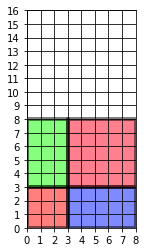

In [421]:
visualize(w, sum(dimsY), n, dims, best_coords_sol)

In [78]:
def __vlsi_sat(w, n, dimsX, dimsY):
    """Solves the given VLSI instance using a SAT encoding.

    It is an auxiliary function. Its aim is to solve the VLSI instance without performing optimization: any solution is good.

    Parameters
    ----------
    w : int
        The width of the plate
    n : int
        The number of circuits
    dimsX : list of int
        Dims X (i.e. width) of the circuits
    dimsY : list of int
        Dims Y (i.e. height) of the circuits
    formulas : list, optional
        List of additional constraints to impose, by default []
    formulas : l_max, optional
        Maximum length of the plate, by default None

    Returns
    -------
    coords_sol: list of tuples of int
        List containing the coordX and coordY of the lower-left vertex of each circuit
    formula_sol: z3.
        Boolean formula containing the solution

    Raises
    ------
    UnsatError
        If the given instance is UNSAT

    Notes
    ------
    The following boolean variables are used
    - circuit_i_j_k, where 'i' in [0,w], 'j' in [0,l_max], 'k' in [0,n]. ('l_max' is the upper bound of the length of the 
      plate).
      '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
       circuit_i_j_k is True IIF the circuit 'k' is present in the cell '(i,j)' of the plate.
    - coord_i_j_k, where 'i' in [0,w], 'j' in [0,l_max], 'k' in [0,n].
      '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
       coord_i_j_k is True IIF the left-bottom corner of the circuit 'k' is put in the cell '(i,j)' of the plate.
    """
    s = Solver()  # Solver instance
    
    # Upper bound of the length of the plate, if not explicitely given in input
    l_max = sum(dimsY)
    
    # List of lists of lists, containing the 'circuits' boolean variables: variables 'circuit_i_j_k'
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    # List of lists of lists, containing the 'coords' boolean variables: variables 'coord_i_j_k'
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]

    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    # Constraint: in each cell '(i,j)' of the plate at most one circuit is present.
    # This reflects both on `circuits` and on `coords`.
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))  # TODO : redundant?
            s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    # Constraint: the left-bottom corner of each circuit 'k' must be present exactly one time across the plate
    for k in range(n):
        s.add(exactly_one([coords[i][j][k] for i in range(w) for j in range(l_max)], name=f'exactly_one_{k}'))

    # Constraint: for each circuit 'k' and for each cell '(i,j)' of the plate, if that cell contains the left-bottom corner 
    # of 'k', then all the cells covered by the circuit 'k' must contain only that circuit and no other circuits.      
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                # Current iteration: circuit `k` and cell `(i,j)` of the plate.
                # Now the constraint about putting the left-bottom corner of `k` in `(i,j)` is ensured.

                # Case in which `k` can't be put in `(i,j)`, because it goes out of the bounds of the plate.
                # In such case, a constraint ensuring that `k` can't be put in `(i,j)` is esnured.
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                    s.add(Not(coords[i][j][k]))  # The left-bottom corner of `k` can't be put in `(i,j)`
                    continue
                
                # List of tuples, representing the coordinates of the cells of the plate covered by the circuit
                covered_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]

                # Formula ensuring that no other circuit is present in the `covered_positions`
                no_overlapping_circuit_formula = And([Not(circuits[ii][jj][kk]) 
                                                      for (ii,jj) in covered_positions for kk in range(n) if kk!=k])
                # Formula ensuring that all the `covered_positions` actually contain that circuit `k`
                all_positions_covered_formula = And([circuits[ii][jj][k] for (ii,jj) in covered_positions])

                formula3 = And([Not(lengths[k][l]) for l in range(j+dimsY[k], l_max)])
                formula4 = And([lengths[k][l] for l in range(j+dimsY[k])])

                # TODO: put negation of all circuits[ii][jj][kk] related to wrong positions? 
                # The added constraint is the following implication: if left-bottom corner of `k` in `(i,j)`, then 
                # `no_overlapping_circuit_formula` and `all_positions_covered_formula`.
                # Actually, it is not an implication, nut an equivalence.
                s.add(coords[i][j][k] == And(no_overlapping_circuit_formula,all_positions_covered_formula))

                s.add(Implies(coords[i][j][k], And(formula3, formula4)))

    # print(s.help())
    # s.set("timeout", 50)
    print('Done')
    
    # Check if UNSAT 
    if s.check() != sat:
        raise UnsatError('UNSAT')
        
    return s

def get_solution(s):  
    # Upper bound of the length of the plate, if not explicitely given in input
    l_max = sum(dimsY)
    
    # List of lists of lists, containing the 'circuits' boolean variables: variables 'circuit_i_j_k'
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    # List of lists of lists, containing the 'coords' boolean variables: variables 'coord_i_j_k'
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]

    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    # Get the solution
    m = s.model()

    # List containing the coordX and coordY of the lower-left vertex of each circuit
    coords_sol = [(i, j) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    # Boolean formula containing the solution
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) 
                  for i in range(w) for j in range(l_max) for k in range(n)])

    l = max([l for k in range(n) for l in range(l_max) if m.evaluate(lengths[k][l])])+1

    return coords_sol, l, formula

In [79]:
s = __vlsi_sat(w, n, dimsX, dimsY)

Done


UnsatError: UNSAT

In [15]:
coords_sol, l, formula = get_solution(s)

In [11]:
coords_sol

[(5, 0), (5, 3), (3, 8), (3, 11)]

In [16]:
coords_sol

[(5, 0), (5, 3), (3, 8), (3, 11)]

In [56]:
def process_solver(s, dimsY, best_l):
    # Upper bound of the length of the plate, if not explicitely given in input
    l_max = sum(dimsY)
    
    # List of lists of lists, containing the 'circuits' boolean variables: variables 'circuit_i_j_k'
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    # List of lists of lists, containing the 'coords' boolean variables: variables 'coord_i_j_k'
    coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]

    lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    # Get the solution
    m = s.model()
    
    # Get the solution
    m = s.model()

    # List containing the coordX and coordY of the lower-left vertex of each circuit
    coords_sol = [(i, j) for k in range(n) for j in range(l_max) for i in range(w) if m.evaluate(coords[i][j][k])]
    # Boolean formula containing the solution
    formula = And([ (coords[i][j][k] if m.evaluate(coords[i][j][k]) else Not(coords[i][j][k])) 
                  for i in range(w) for j in range(l_max) for k in range(n)])
    print(type(formula))

    l = max([l for k in range(n) for l in range(l_max) if m.evaluate(lengths[k][l])])+1
    
    #s.push()
    
    s.add(Not(formula))    
    if not best_l:
        best_l = l_max
    s.add(And([Not(lengths[k][ll]) for k in range(n) for ll in range(l-2,best_l-1)]))
    
    return coords_sol, l

In [47]:
def vlsi_sat(w, n, dims):
    """Solves the given VLSI instance using a SAT encoding.

    It performs optimization: the best solution is returned (if any).

    Parameters
    ----------
    w : int
        The width of the plate
    n : int
        The number of circuits
    dims : list of tuple of int
        Dims X and Y (i.e. width and height) of the circuits

    Returns
    -------
    best_coords: list of tuples of int
        List containing the coordX and coordY of the lower-left vertex of each circuit in the best solution
    best_l: int
        Length of the plate in the best solution

    Raises
    ------
    UnsatError
        If the given instance is UNSAT

    Notes
    ------
    The implementation is based on the usage of the `__vlsi_sat` auxiliary function.
    Basically, a loop iterating over all the possible solutions is performed, searching for the best possible solution.
    """
    # Splitting `dims` into `dimsX` and `dimsY`
    dimsX = [dims[i][0] for i in range(n)]
    dimsY = [dims[i][1] for i in range(n)]

    # Boolean flag reprenting if the first solution has not been found yet
    # first = True
    best_l = None
    
    try:
        # Search for a solution (given the additional constraints in `formulas`)
        s = __vlsi_sat(w, n, dimsX, dimsY)
        print(type(s))
        best_coords, best_l = process_solver(s, dimsY, best_l)
        print(best_coords)
        print(best_l)
    except:
        raise UnsatError('UNSAT')
    
    # Loop iterating over all the possible solutions, searching for the best one
    while True:
        if s.check()!=sat:
            break
        best_coords, best_l = process_solver(s, dimsY, best_l)
        print(best_coords)
        print(best_l)
    
    return best_coords, best_l 

In [57]:
%%time
coords, l = vlsi_sat(w, n, dims)

UnsatError: UNSAT

In [42]:
l

8

In [268]:
def __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max):
    """Solves the given VLSI instance using a SAT encoding.

    It is an auxiliary function. Its aim is to solve the VLSI instance without performing optimization: any solution is good.

    Parameters
    ----------
    w : int
        The width of the plate
    n : int
        The number of circuits
    dimsX : list of int
        Dims X (i.e. width) of the circuits
    dimsY : list of int
        Dims Y (i.e. height) of the circuits
    l_max : int
        Upper bound of the length of the plate

    Returns
    -------
    s: z3.z3.Solver
        The solver instance
    coords : list of list of list of z3.z3.BoolRef
        Boolean variables 'coord_i_j_k'.
        See `Notes`.
    lengths : list of list of z3.z3.BoolRef
        Boolean variables 'length_k_l'.
        See `Notes`.

    Notes
    ------
    The following boolean variables are used
    - circuit_i_j_k, where 'i' in [0,w], 'j' in [0,l_max], 'k' in [0,n]. ('l_max' is the upper bound of the length of the 
      plate).
      '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
       circuit_i_j_k is True IIF the circuit 'k' is present in the cell '(i,j)' of the plate.
    - coord_i_j_k, where 'i' in [0,w], 'j' in [0,l_max], 'k' in [0,n].
      '(i,j)' represent two coordinates of the plate, 'k' represents a circuit.
       coord_i_j_k is True IIF the left-bottom corner of the circuit 'k' is put in the cell '(i,j)' of the plate.
    - length_k_l, where 'k' in [0,n] and 'l' in [0,l_max], 'k' in [0,n].
      'k' represent represents a circuit, 'l' represents a length of the plate.
       length_k_l is True IIF the circuit 'k' uses the length 'l' of the plate.
    """
    s = Solver()  # Solver instance
    
    # Upper bound of the length of the plate, if not explicitely given in input
    l_max = sum(dimsY)
    
    # List of lists of lists, containing the 'circuits' boolean variables: variables 'circuit_i_j_k'
    circuits = [[[Bool(f'circuit_{i}_{j}_{k}') for k in range(n)] for j in range(l_max)] for i in range(w)]
    # List of lists of lists, containing the 'coords' boolean variables: variables 'coord_i_j_k'
    # coords = [[[Bool(f'coord_{i}_{j}_{k}') for k in range(n)] for j in range(l_max-h_min+1)] for i in range(w-w_min+1)]
    # List of lists of lists, containing the 'lengths' boolean variables: variables 'length_k_l'
    #lengths = [[Bool(f'length_{k}_{l}') for l in range(l_max)] for k in range(n)]
    
    # Constraint: in each cell '(i,j)' of the plate at most one circuit is present.
    # This reflects both on `circuits` and on `coords`.
    for i in range(w):
        for j in range(l_max):
            s.add(at_most_one(circuits[i][j], name=f'at_most_one_circuit_{i}_{j}'))  # TODO : redundant?
            #s.add(at_most_one(coords[i][j], name=f'at_most_one_coord_{i}_{j}'))
            
    # Constraint: the left-bottom corner of each circuit 'k' must be present exactly one time across the plate
    #for k in range(n):
    #    s.add(exactly_one([coords[i][j][k] for i in range(w-w_min+1) for j in range(l_max-h_min+1)], name=f'exactly_one_{k}'))

    print('CUCU')  # TODO: remove

    formulas = []
    # Constraint: for each circuit 'k' and for each cell '(i,j)' of the plate, if that cell contains the left-bottom corner 
    # of 'k', then all the cells covered by the circuit 'k' must contain only that circuit and no other circuits.      
    for k in range(n):
        for i in range(w):
            for j in range(l_max):
                # Current iteration: circuit `k` and cell `(i,j)` of the plate.
                # Now the constraint about putting the left-bottom corner of `k` in `(i,j)` is ensured.

                # Case in which `k` can't be put in `(i,j)`, because it goes out of the bounds of the plate.
                # In such case, a constraint ensuring that `k` can't be put in `(i,j)` is esnured.
                if i+dimsX[k]-1>=w or j+dimsY[k]-1>=l_max:
                #    s.add(Not(coords[i][j][k]))  # The left-bottom corner of `k` can't be put in `(i,j)`
                    #covered_positions = [(i+ii,j+jj) for ii in range(1,dimsX[k]) for jj in range(1,dimsY[k])
                                                     #if i+ii-1<w and j+jj- ]
                    #s.add(And([Not(circuits[ii][jj][k]) for (ii,jj) in covered_positions]))
                    continue
                
                # List of tuples, representing the coordinates of the cells of the plate covered by the circuit
                covered_positions = [(i+ii,j+jj) for ii in range(dimsX[k]) for jj in range(dimsY[k])]
                #non_covered_positions = list(set([(ii,jj) for ii in range(w) for jj in range(l_max)]) 
                #                             - set(covered_positions))
                non_covered_positions = [(ii,jj) for ii in range(w) for jj in range(l_max) if (ii,jj) not in covered_positions]
                print(covered_positions)
                print(sorted(non_covered_positions))

                # Formula ensuring that no other circuit is present in the `covered_positions`
                #no_overlapping_circuit_formula = And([Not(circuits[ii][jj][kk]) 
                #                                      for (ii,jj) in covered_positions for kk in range(n) if kk!=k])
                # Formula ensuring that all the `covered_positions` actually contain that circuit `k`
                all_positions_covered_formula = And([circuits[ii][jj][k] for (ii,jj) in covered_positions])                
                #all_positions_not_covered_formula = And([Not(circuits[ii][jj][k]) for (ii,jj) in non_covered_positions])
                #formulas.append(And(all_positions_covered_formula,all_positions_not_covered_formula))
                formulas.append(all_positions_covered_formula)
                
                # TODO: put negation of all circuits[ii][jj][k] related to wrong positions? 
                # The added constraint is the following implication: if left-bottom corner of `k` in `(i,j)`, then 
                # `no_overlapping_circuit_formula` and `all_positions_covered_formula`.
                # Actually, it is not an implication, nut an equivalence.
                #s.add(coords[i][j][k] == And(no_overlapping_circuit_formula,all_positions_covered_formula))

                # Formula ensuring that all the lengths up to `j+dimsY[k]-1` are used by the circuit `k`
                #used_lengths_formula = And([lengths[k][l] for l in range(j+dimsY[k]-l_min+1)])
                # Formula ensuring that all the lengths from `j+dimsY[k]` are not used by the circuit `k`
                #non_used_lengths_formula = And([Not(lengths[k][l]) for l in range(j+dimsY[k]-l_min+1, l_max-l_min+1)])
                # The added constraint is the following implication: if left-bottom corner of `k` in `(i,j)`, then 
                # `used_lengths_formula` and `non_used_lengths_formula`.
                #s.add(Implies(coords[i][j][k], And(used_lengths_formula, non_used_lengths_formula)))
        #s.add(exactly_one(formulas, name=f'exactly_one_{k}'))
        s.add(Or(formulas))

    print('HERE')  # TODO: remove

    # Check if UNSAT 
    if s.check() != sat:
        raise UnsatError('UNSAT')
        
    return s, circuits

In [269]:
from math import ceil

dimsX = [dims[i][0] for i in range(n)]
dimsY = [dims[i][1] for i in range(n)]

areas = [dimsX[i]*dimsY[i] for i in range(n)]  # The areas of the circuits
A_tot = sum(areas)  # The overall area of all the given circuits
h_min = min(dimsY)  # The minimum height of a circuit
h_max = max(dimsY)  # The maximum height of a circuit
w_min = min(dimsX)  # The minimum width of a circuit
w_max = max(dimsX)  # The maximum width of a circuit
l_min = max([h_max, A_tot // w])  # The lower bound for the length
min_rects_per_row = w // w_max  # Minimum number of circuits per row
max_rects_per_col = ceil(n / max([1, min_rects_per_row]))  # Maximum number of circuits per column
# The upper bound for the length
#l_max =  sum(sorted(dimsY)[n-max_rects_per_col:])
sorted_dimsY = sorted(dimsY, reverse=True)
l_max = sum(dimsY)

In [270]:
s, circuits = __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max)

CUCU
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
[(0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3)]
[(0, 0), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
[(0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4)]
[(0, 0), (0, 1), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)]
[(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5)]
[(0, 0), (0, 1), (0, 2), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3,

In [271]:
m = s.model()
coords = []
for k in range(n):
    for i in range(w):
        for j in range(l_max):
            if m.evaluate(circuits[i][j][k]):
                coords.append((i,j))
                break
        else:
            continue
        break

In [272]:
print(m)

[circuit_1_4_1 = False,
 circuit_3_5_0 = True,
 circuit_0_1_1 = False,
 circuit_0_1_0 = True,
 circuit_1_6_1 = False,
 circuit_0_0_0 = True,
 circuit_2_2_0 = True,
 circuit_3_4_0 = True,
 circuit_0_0_1 = False,
 circuit_0_2_1 = False,
 circuit_1_7_0 = True,
 circuit_3_5_1 = False,
 circuit_1_1_1 = False,
 circuit_3_1_1 = False,
 circuit_0_5_1 = False,
 circuit_3_4_1 = False,
 circuit_2_1_1 = False,
 circuit_3_7_1 = False,
 circuit_0_5_0 = True,
 circuit_1_3_0 = True,
 circuit_1_5_0 = True,
 circuit_1_6_0 = True,
 circuit_2_5_1 = False,
 circuit_0_4_1 = False,
 circuit_0_2_0 = True,
 circuit_1_2_0 = True,
 circuit_2_0_1 = False,
 circuit_2_5_0 = True,
 circuit_1_0_1 = False,
 circuit_3_1_0 = True,
 circuit_1_0_0 = True,
 circuit_2_6_1 = False,
 circuit_2_3_1 = False,
 circuit_3_3_1 = False,
 circuit_1_5_1 = False,
 circuit_0_7_0 = True,
 circuit_2_7_0 = True,
 circuit_1_2_1 = False,
 circuit_3_6_0 = True,
 circuit_3_2_0 = True,
 circuit_0_6_0 = True,
 circuit_1_7_1 = False,
 circuit_2_2

In [267]:
coords

[(0, 0)]

In [261]:
visualize(w, sum(dimsY), n, dims, coords)

IndexError: list index out of range

In [90]:
s, circuits = __vlsi_sat(w, n, dimsX, dimsY, w_min, h_min, l_min, l_max)

CUCU
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6),

[(1, 12), (1, 13), (1, 14), (2, 12), (2, 13), (2, 14), (3, 12), (3, 13), (3, 14)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(3, 8), (3, 9), (3, 10), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (5, 10)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(5, 6), (5, 7), (5, 8), (6, 6), (6, 7), (6, 8), (7, 6), (7, 7), (7, 8)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 

[(0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2)]
[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(1, 8), (1, 9), (1, 10), (2, 8), (2, 9), (2, 10), (3, 8), (3, 9), (3, 10), (4, 8), (4, 9), (4, 10), (5, 8), (5, 9), (5, 10)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3), (6, 1), (6, 2), (6, 3), (7, 1), (7, 2), (7, 3)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 4), (7, 5), (7, 6), (7, 

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]
[(0, 0), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

[(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 0), (2, 1), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (3, 0), (3, 1), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (4, 0), (4, 1), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (5, 0), (5, 1), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (6, 0), (6, 1), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 

HERE
